<a href="https://colab.research.google.com/github/DaryaVish/first-project/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование заказов в такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots
from statsmodels.tools.eval_measures import rmse
from sklearn.compose import make_column_transformer

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

RANDOM_STATE = 42

import warnings
warnings.filterwarnings("ignore")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0])
display(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Датасет состоит из 26,5 тысяч строк и двух признаков: даты и времени заказа такси и количества заказов за последние 10 минут. Так как задача спрогнозировать количество заказов такси на следующий час, значит необходимо ресемплировать данные по часу.
Пропусков в данных нет.

# Предобработка и анализ данных

Ресемплируем данные по одному часу

In [6]:
data = df.set_index('datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


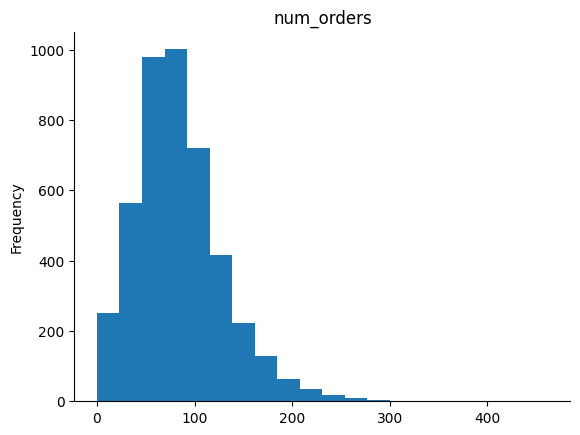

In [11]:
# @title num_orders

from matplotlib import pyplot as plt
data['num_orders'].plot(kind='hist', bins=20, title='num_orders')
plt.gca().spines[['top', 'right',]].set_visible(False)

Признак num_orders имеет нормальное распределение

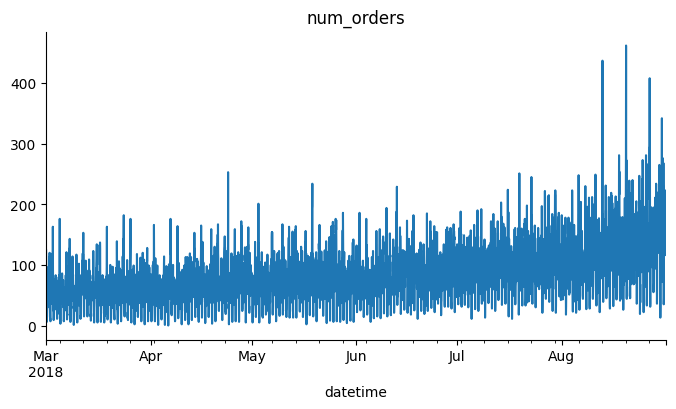

In [12]:
# @title num_orders

from matplotlib import pyplot as plt
data['num_orders'].plot(kind='line', figsize=(8, 4), title='num_orders')
plt.gca().spines[['top', 'right']].set_visible(False)

Данные хранятся в 4416 объектах и состоят из даты и времени и количества заказов в этот временной промежуток, шаг горизонта событий равен часу. Все наблюдения велись с 2018-03-01 00:00:00 до 2018-08-31 23:50:00.

<Figure size 1500x800 with 0 Axes>

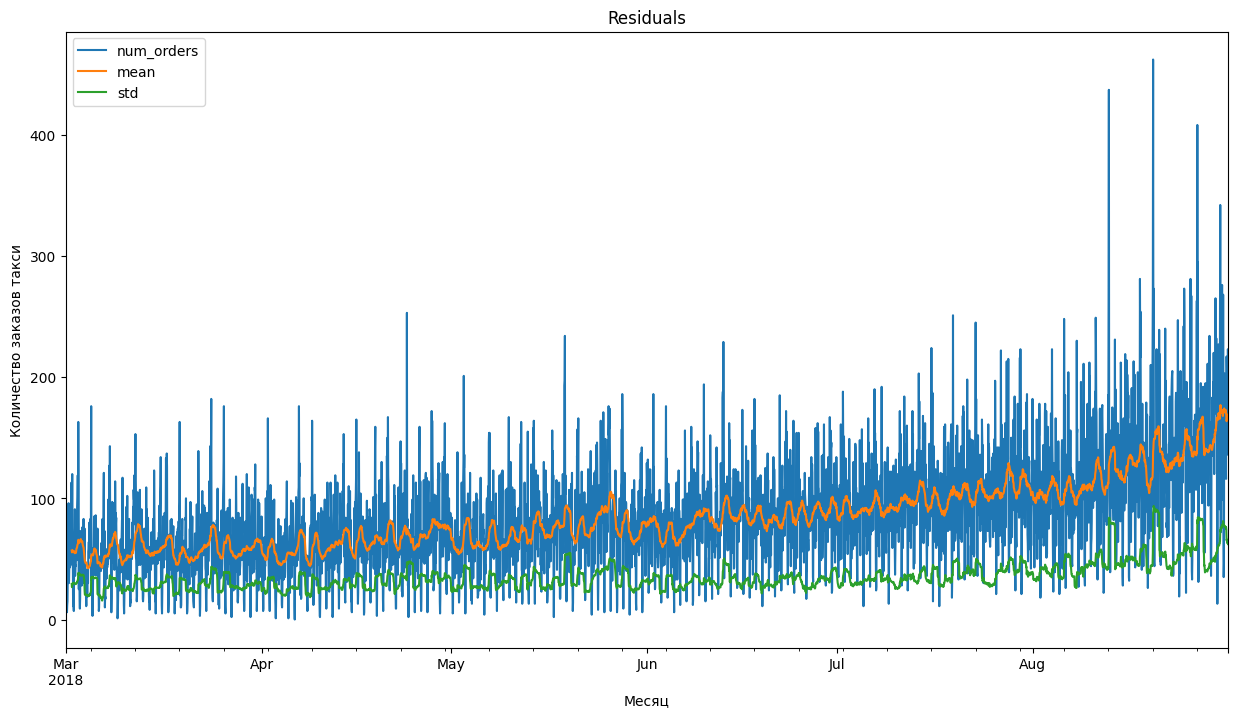

In [13]:
plt.figure(figsize=(15,8))
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot(figsize=(15, 8))
plt.title('Residuals')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов такси');

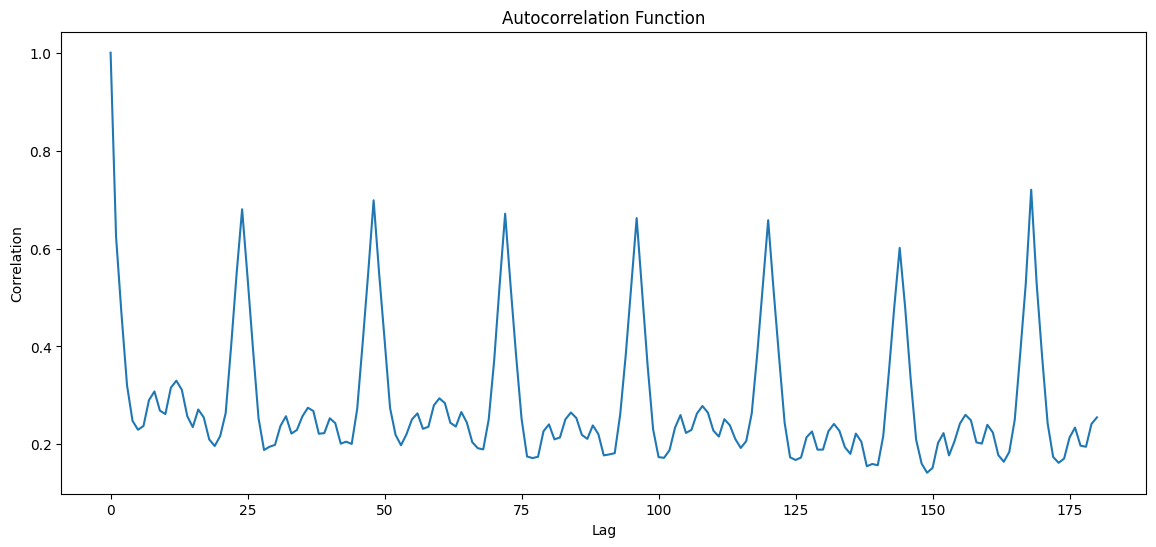

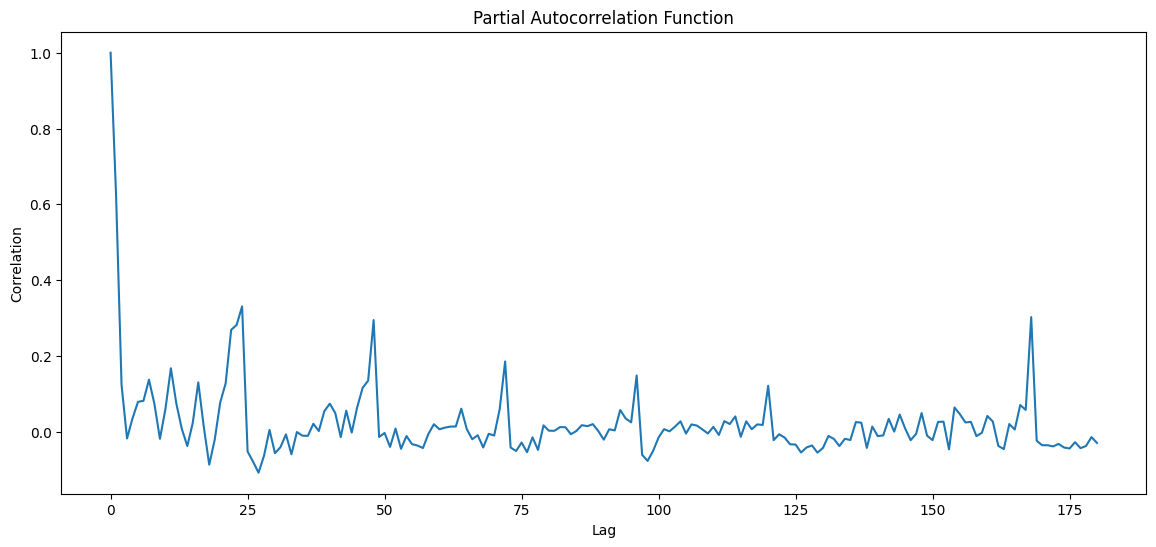

In [14]:
# Построение ACF
lag_acf = acf(data['num_orders'], nlags=180)
plt.figure(figsize=(14,6))
plt.plot(lag_acf)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Построение PACF
lag_pacf = pacf(data['num_orders'], nlags=180)
plt.figure(figsize=(14,6))
plt.plot(lag_pacf)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

На графике автокорреляции видны пики каждые 24 часа что говорит нам о явной суточной сезонности. На pacf также заметен сильный пик на знаении 168, что может говорить о недельной сезонности.

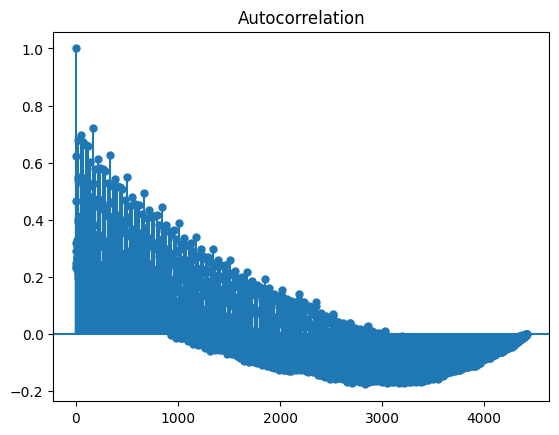

In [15]:
# применим функцию к набору данных
plot_acf(data['num_orders'], lags = np.arange(len(data['num_orders'])), alpha = None)

# добавим отступы сверху и снизу на графике
plt.axis('tight')
plt.show()

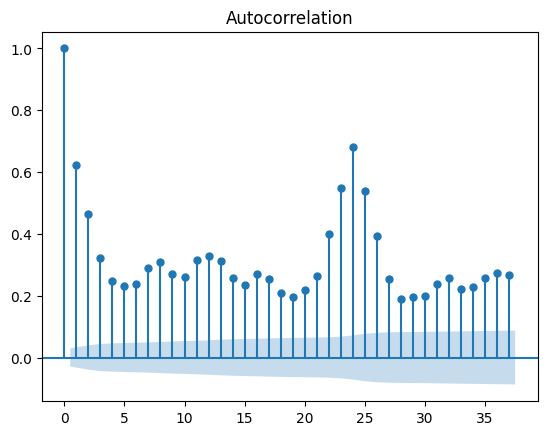

In [16]:
plot_acf(data['num_orders'])
plt.axis('tight')
plt.show()

Взглянем на тренды, сезонность и остатки. Выберем промежуток в течение трёх недель августа с 6.08 по 26.08 для наглядности графика

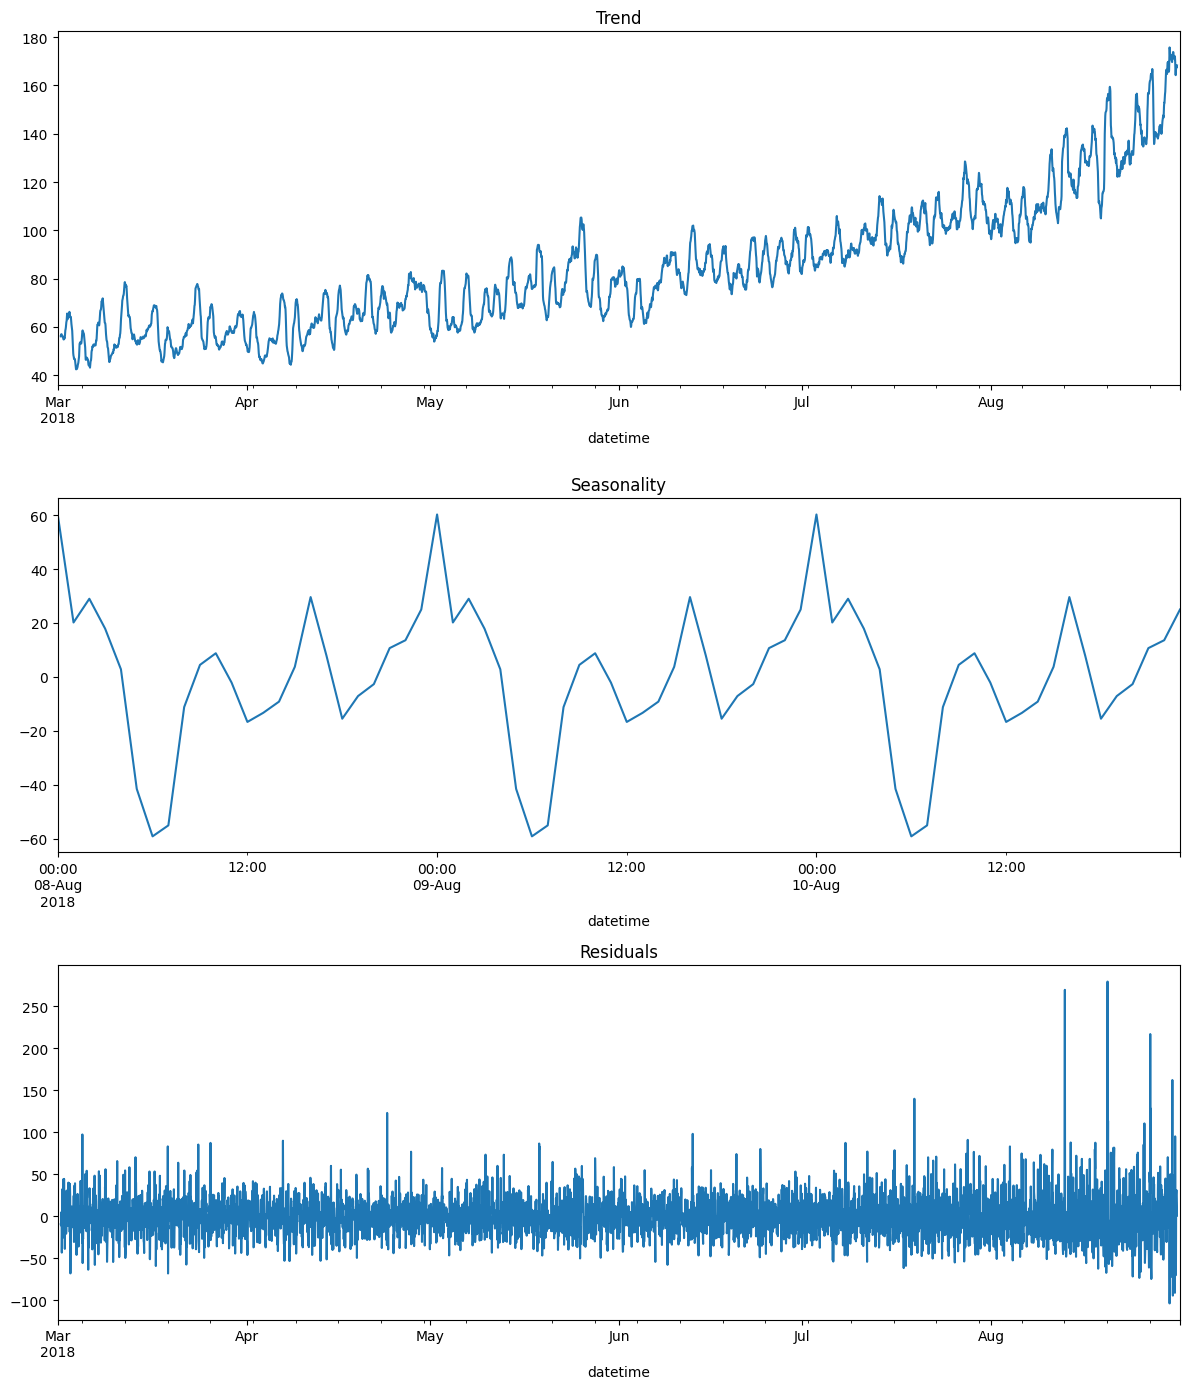

In [17]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 14))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-08': '2018-08-10'].plot(ax=plt.gca())
plt.title('Seasonality')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд снижения заказов с субботы по воскресенье: с 11.08 по 12.08 и с 18.08 по 19.08. Суточная сезонность: ночью снижение количества заказов, а в часы пик повышение. Так же в данных четко прослеживается недельная сезонность.

Возможно увеличивающийся тренд с марта по август говорит о новых пользователях "Чётенького такси", связан он скорее всего с раскрученностью приложения. Больше всего заказов такси приходится на понедельник, среду и пятницу. Пользователи активно вызывают такси в часы пик и примерно до 2 часов ночи.

# Создадим новые признаки для моделей Rige и Catboost

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 168, 168)

,num_orders,mean,std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,63.268908,19,4,207.0,217.0,197.0,116.0,133.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,154.297619
2018-08-31 20:00:00,154,168.041667,63.105487,20,4,136.0,207.0,217.0,197.0,116.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,154.434524
2018-08-31 21:00:00,159,166.416667,62.801908,21,4,154.0,136.0,207.0,217.0,197.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,154.285714


In [19]:
data['hour'] = data['hour'].astype(object)
data['dayofweek'] = data['dayofweek'].astype(object)

In [20]:
data = data.drop(columns=['mean','std'])
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобьем данные на test и train

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.shape, test.shape)

(3806, 172) (442, 172)


Выделим фичи и таргет

In [22]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

print(f'train: {X_train.shape}, test: {X_test.shape}')

train: (3806, 171), test: (442, 171)


Разделим категориальные и количественные признаки

In [23]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

In [24]:
cat_features = ['hour', 'dayofweek']

# Обучение моделей с кросс валидацией: CatBoost и Rige

**CatBoost**

In [25]:
tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X_train):
    # Разделение данных на обучающую и валидационную выборки
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    # Создание Pool для обучения и валидации
    train_pool = Pool(data=X_tr, label=y_tr, cat_features=cat_features)
    val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

    # Инициализация и обучение модели
    params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.1,
        'random_seed': 42,
        'verbose': 100
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool)

    # Оценка модели
    predictions = model.predict(val_pool)
    score = (mean_squared_error(y_val, predictions)) ** 0.5
    scores.append(score)
    CB_model = min(scores)

# Вывод среднеквадратичного корня из среднеквадратичной ошибки
print('RMSE:', sum(scores) / len(scores))

0:	learn: 28.1579760	test: 31.6040376	best: 31.6040376 (0)	total: 152ms	remaining: 2m 32s
100:	learn: 8.9579150	test: 20.0760039	best: 20.0213177 (96)	total: 7.48s	remaining: 1m 6s
200:	learn: 4.4296768	test: 20.1215966	best: 20.0008143 (115)	total: 11s	remaining: 43.7s
300:	learn: 2.3632682	test: 20.1988533	best: 20.0008143 (115)	total: 13.4s	remaining: 31.2s
400:	learn: 1.2831144	test: 20.1662562	best: 20.0008143 (115)	total: 17.3s	remaining: 25.8s
500:	learn: 0.6616381	test: 20.1600531	best: 20.0008143 (115)	total: 19.8s	remaining: 19.7s
600:	learn: 0.3461399	test: 20.1571042	best: 20.0008143 (115)	total: 22.2s	remaining: 14.7s
700:	learn: 0.1959964	test: 20.1555975	best: 20.0008143 (115)	total: 24.6s	remaining: 10.5s
800:	learn: 0.1161168	test: 20.1560203	best: 20.0008143 (115)	total: 27.2s	remaining: 6.77s
900:	learn: 0.0710663	test: 20.1551051	best: 20.0008143 (115)	total: 30.8s	remaining: 3.38s
999:	learn: 0.0461611	test: 20.1543519	best: 20.0008143 (115)	total: 33.2s	remaining:

In [26]:
print("Best validation RMSE score: {:.4f}".format(
CB_model))

Best validation RMSE score: 20.0008


Создадим column transformer

In [27]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough'
)

In [28]:
pd.options.display.float_format = '{:.2f}'.format

**Ridge**

In [29]:
model_ridge = Ridge(random_state=RANDOM_STATE)
pipeline_ridge = make_pipeline(col_transformer, model_ridge)

param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge, cv=tscv,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_ridge_pl.fit(X_train, y_train)

gs_ridge_best_score = gs_ridge_pl.best_score_ * -1
gs_ridge_best_params = gs_ridge_pl.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge_best_score}')
# Best hyperparameters
print(f'best_params: {gs_ridge_best_params}')

# print(gs_ridge_pl.cv_results_)

best_score: 22.90042613023789
best_params: {'ridge__alpha': np.float64(0.2)}


Сравним результаты обученных моделей в таблице:

In [30]:
model_data = {
'model_name': ['CatBoost_Regressor', 'Ridge'],
'RMSE': [CB_model, gs_ridge_best_score]}

df = pd.DataFrame.from_dict(model_data)
df

,model_name,RMSE
0,CatBoost_Regressor,20.00
1,Ridge,22.90


CatBoost Regressor показал наилучший rmse 20 против 22.9 модели Ridge. Предскажем rколичество заказов в такси на следующий час с помощью CatBoost.

In [31]:
test_data_CB = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [32]:
params = {'cat_features': cat_features,
          'loss_function': 'RMSE',
          'learning_rate': 0.1,
          'random_seed': 2007,
          'verbose':100}

In [33]:
model = CatBoostRegressor(**params)

In [34]:
train_data_CB = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

In [35]:
model.fit(train_data_CB)

0:	learn: 36.5535719	total: 53ms	remaining: 53s
100:	learn: 17.9359481	total: 5.35s	remaining: 47.6s
200:	learn: 15.0447978	total: 9.27s	remaining: 36.9s
300:	learn: 12.5547535	total: 13.4s	remaining: 31.1s
400:	learn: 10.6303058	total: 18.7s	remaining: 27.9s
500:	learn: 9.1904027	total: 22.7s	remaining: 22.6s
600:	learn: 7.9081089	total: 27.2s	remaining: 18s
700:	learn: 6.8108004	total: 32s	remaining: 13.6s
800:	learn: 5.8910852	total: 36s	remaining: 8.94s
900:	learn: 5.0913995	total: 41s	remaining: 4.5s
999:	learn: 4.4088553	total: 45.3s	remaining: 0us


In [36]:
pred = model.predict(test_data_CB)

In [37]:
metric_test = sqrt(mean_squared_error(y_test, pred))
metric_test

np.float64(37.15073669239567)

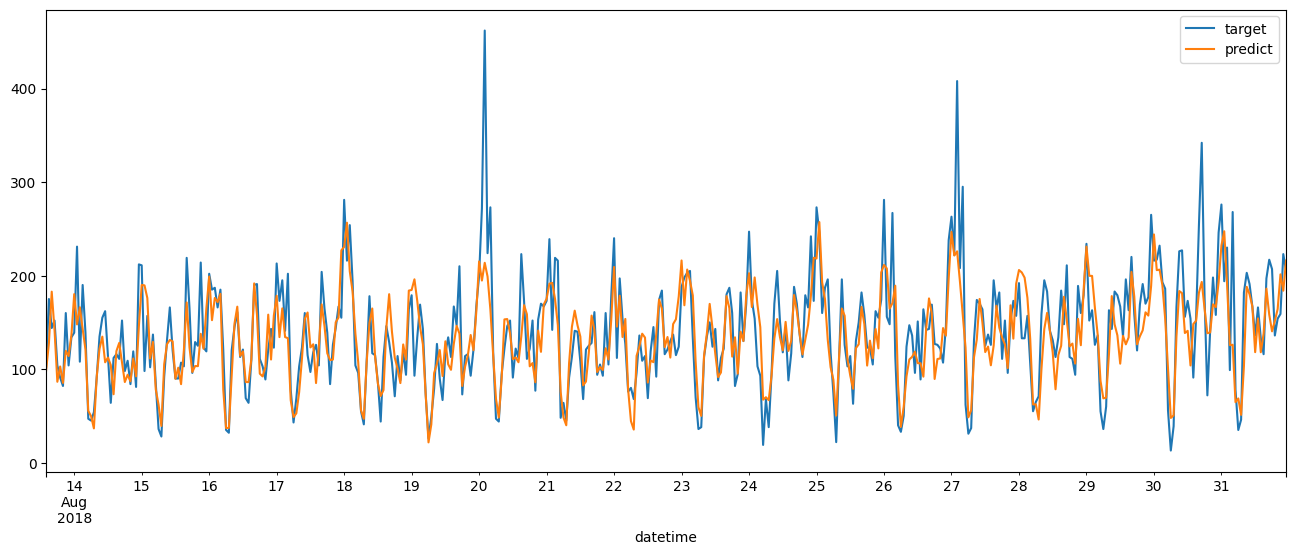

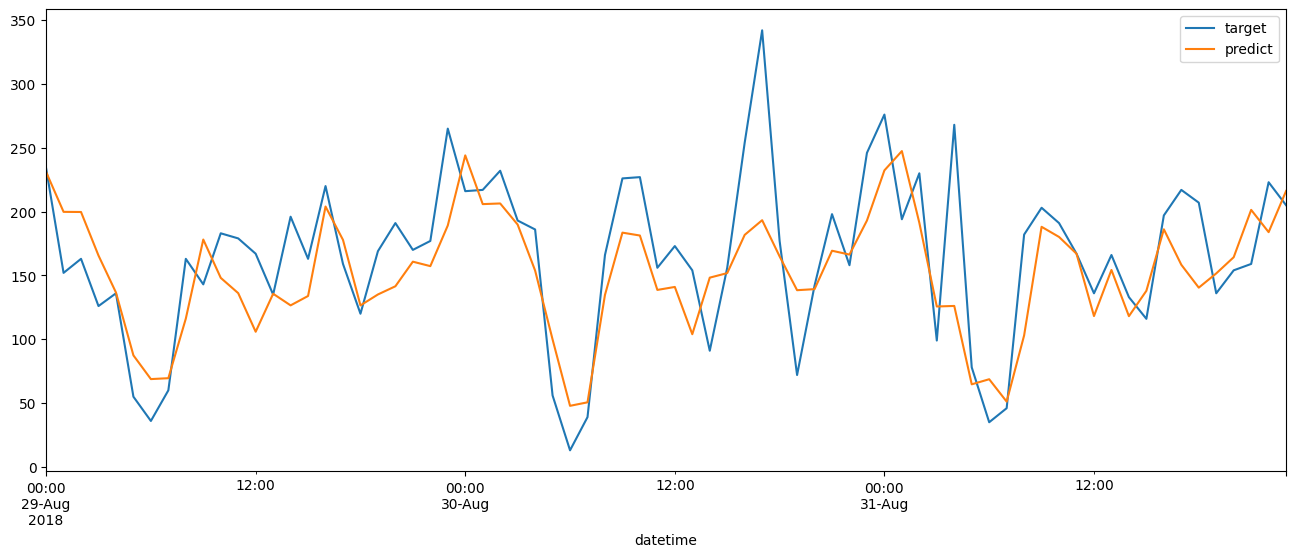

In [38]:
mod_data = pd.DataFrame({"target":y_test, "predict":pred})
mod_data.plot(figsize=(16, 6))
mod_data['2018-08-29':'2018-08-31'].plot(figsize=(16, 6));

Можно сделать вывод, что модель предсказывает довольно неплохо, только на некоторых пиках по средним значениям.

Тест на адекватность модели. Предскажем предыдущим членом ряда

In [39]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_test.iloc[-1]
actual_rmse = sqrt(mean_squared_error(y_test, pred_previous))

print('RMSE для проверки модели на адекватность:', (round(actual_rmse, 2)))

RMSE для проверки модели на адекватность: 59.05


# Вывод:



 Анализ данных


1.   Графики показывают четкую суточную и недельную сезонность в количестве заказов.
2.   В ночное время количество заказов приближается к нулю, а вечером наблюдается пик популярности такси.



 Дополнительные признаки



В данные были добавлены новые характеристики: день недели и отстающие значения.
Эти признаки помогают модели лучше понять закономерности в данных.


 Оптимизация гиперпараметров



Был создан отдельный набор данных для выбора оптимальных параметров моделей.
Этот процесс позволяет улучшить производительность моделей.
Тестирование моделей
Все примененные модели достигли желаемого уровня точности по метрике RMSE.
Однако анализ показал, что модели имеют трудности с предсказанием на пиковых значениях и в периоды низкой активности.


 Анализ моделей

CatBoost Regressor показал наименьший rmse 20. Для предсказания я выбрала CatBoost.
Модель Ridge на кросс валидации показала результат RMSE 22.9, что тоже неплохо.
Результат предсказания на тестовой выборке получился 37.1. Модель проверена на адекватность с помощью предсказания предыдущим членом ряда, результат метрики составил 59.05. Обученная модель CatBoost Regressor имеет хорошую прогностическую способность, как видно на графике факт-прогноз выше.



